In [1]:
#Multi-Layer Perceptron (MLP) model
#MLPs are a type of feedforward neural network that consists of multiple layers of neurons
#easy to implement, train and understand the working of the model. It also has a good performance on this dataset and it is a good starting point to experiment with other architectures.
#MNIST is a dataset of handwritten digits, and it has been widely used as a benchmark for image classification tasks. MLPs are capable of achieving high accuracy on image classification tasks. 
#So hoping that Mnist, FashionMnist and permuted images, all these mixed data set also will give good accuracy like Mnist and FashionMnist data set 

In [4]:
import torch
import torchvision.transforms as transforms
import pandas as pd

import torch.nn as nn

import torchvision.datasets as datasets

import matplotlib.pylab as plt
import numpy as np

import cv2
import time

from torch.utils.data import Dataset
from torch.utils.data import DataLoader



In [2]:
# Load the .csv file into a Pandas DataFrame
df_training = pd.read_csv('/home/bibin/MAI/2nd_sem/ANN/dataset/train.csv')
df_training 

,id,image,classification
0,0,2_000000.png,7
1,1,0_000001.png,2
2,2,1_000002.png,7
3,3,3_000003.png,4
4,4,1_000004.png,3
...,...,...,...
239995,239995,2_239995.png,4
239996,239996,1_239996.png,5
239997,239997,3_239997.png,7
239998,239998,3_239998.png,1


In [2]:
image = df_training['image'].to_list()
labels = df_training['classification'].to_list()
#using the Pandas library to extract the 'image' and 'classification' columns from the DataFrame "df_training" and converting them into lists

In [4]:
zero = np.zeros((240000,28,28),dtype=np.uint8) #creates 2-D array of 240000 rows and 28*28 columns
                                               

In [5]:
for i in range(240000):
    zero[i] = cv2.imread(f'dataset/train/{labels[i]}/{image[i]}',0)
#reading  images using  OpenCV library
#converting it to grayscale by passing the parameter 0
#image is then assigned to the corresponding index in the "zero" array created before

In [6]:
zero = zero/255 #normalizes the image pixel values between 0 and 1 

In [7]:
images = torch.FloatTensor(zero).reshape((240000,1,28,28)) # convert from numpy array into torch tensor with shape(240000,1,28,28)

In [8]:
classes = torch.tensor(labels)
classes = classes.type(torch.LongTensor)
#converting the datatype of the tensor to LongTensor. LongTensor is a 64-bit integer tensor, which is used to store the labels of the dataset. This is done to perform operations on the labels data in the Pytorch framework.

In [9]:
classes

tensor([7, 2, 7,  ..., 7, 1, 8])

In [10]:
#creating a custom dataset
#combining correspoding images and labels  into one training dataset 
class ImageLabelDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return (image, label)


training_set = ImageLabelDataset(images, classes)

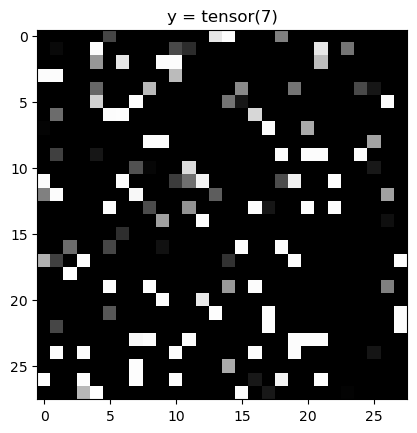

In [11]:
#using the matplotlib library to display the image
def shows_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(28, 28), cmap='gray') #convert the image tensor to a numpy array then reshaping it to (28,28) to match the original image size
    plt.title('y = ' + str(data_sample[1]))
shows_data(training_set[0])

In [12]:
train_loader = DataLoader(training_set, batch_size=32, shuffle=True)
#shuffle set to true means the data will be randomly shuffled before each training epoch
#data loader is used to load the data in mini-batches during training. It is an iterator that returns a batch of data on each call. This allows for loading data in a memory-efficient way, especially when working with large datasets.

In [16]:
# Create the model class using Relu as a activation function

class NetRelu(nn.Module):
    def __init__(self, D_in, H1, H2, H3, H4, H5, H6, D_out): #init() method is used to initialize the class. It takes seven parameters 'D_in', 'H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'D_out' and creates an instance variable for each parameter. It also creates 7 nn.Linear layers and 6 nn.BatchNorm1d layers
        super(NetRelu, self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        nn.init.xavier_uniform_(self.linear1.weight) #The Xavier initialization is used to initialize the weights of each linear layer.
        self.linear2 = nn.Linear(H1, H2)
        nn.init.xavier_uniform_(self.linear2.weight) #Xavier initialization speeds up the convergence of the network 
        self.linear3 = nn.Linear(H2, H3)
        nn.init.xavier_uniform_(self.linear3.weight)
        self.linear4 = nn.Linear(H3, H4)
        nn.init.xavier_uniform_(self.linear4.weight)
        self.linear5 = nn.Linear(H4, H5)
        nn.init.xavier_uniform_(self.linear5.weight)
        self.linear6 = nn.Linear(H5, H6)
        nn.init.xavier_uniform_(self.linear6.weight)
        self.linear7 = nn.Linear(H6, D_out)
        nn.init.xavier_uniform_(self.linear7.weight)
        self.bn1 = nn.BatchNorm1d(H1)
        self.bn2 = nn.BatchNorm1d(H2)  #BatchNormalization: normalize the outputs of each linear layer across the mini-batch 
        self.bn3 = nn.BatchNorm1d(H3)
        self.bn4 = nn.BatchNorm1d(H4)
        self.bn5 = nn.BatchNorm1d(H5)
        self.bn6 = nn.BatchNorm1d(H6)
    
    # Prediction
    def forward(self, x): #forward() method is used to define the forward pass of the network. It takes an input tensor 'x' as a parameter. It applies the relu activation function to each linear layer followed by batch normalization and passes the output of each layer to the next one. Then it returns the output of the final linear layer
        x = self.bn1(torch.relu(self.linear1(x)))  #used relu activation function
        x = self.bn2(torch.relu(self.linear2(x)))
        x = self.bn3(torch.relu(self.linear3(x)))
        x = self.bn4(torch.relu(self.linear4(x)))
        x = self.bn5(torch.relu(self.linear5(x)))
        x = self.bn6(torch.relu(self.linear6(x)))
        x = self.linear7(x)
        return x

In [17]:
# Create the criterion function
# measure of how well the network is performing on the training set
criterion = nn.CrossEntropyLoss()

In [18]:
# Set the parameters for create the model

input_dim = 784
hidden_dim1 = 640
hidden_dim2 = 512
hidden_dim3 = 384
hidden_dim4 = 256
hidden_dim5 = 64
hidden_dim6 = 32
output_dim = 10
learning_rate = 0.0001



In [19]:
# Train a model with Relu function

modelRelu = NetRelu(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, hidden_dim6, output_dim)
optimizer = torch.optim.Adam(modelRelu.parameters(), lr=learning_rate) #extension of the stochastic gradient descent (SGD) algorithm

In [20]:
# defining model training

n_epochs = 100
loss_list = []
print_interval = 1

def train_model(n_epochs):
    for epoch in range(n_epochs):
        start_time = time.time()
        for x, y in train_loader:
            
            # Zero the gradients
            optimizer.zero_grad() 
            
            # Forward pass
            z = modelRelu(x.view(-1, 784))   
            loss = criterion(z, y)
            
            # Backward pass
            loss.backward()
            
            # Update the weights
            optimizer.step()
            
            loss_list.append(loss.data.item())
            
        elapsed_time = time.time() - start_time
        print('Elapsed time for epoch {}: {:.2f} seconds'.format(epoch+1, elapsed_time))
         # Print the loss at the specified interval
        if epoch % print_interval == 0:
            print(f'Epoch {epoch}: Loss = {loss.data.item():.4f}')   


In [21]:
#training model
train_model(n_epochs)

Elapsed time for epoch 1: 104.48 seconds
Epoch 0: Loss = 0.3736
Elapsed time for epoch 2: 92.33 seconds
Epoch 1: Loss = 0.3576
Elapsed time for epoch 3: 92.09 seconds
Epoch 2: Loss = 0.2047
Elapsed time for epoch 4: 96.87 seconds
Epoch 3: Loss = 0.0444
Elapsed time for epoch 5: 92.91 seconds
Epoch 4: Loss = 0.2252
Elapsed time for epoch 6: 94.40 seconds
Epoch 5: Loss = 0.0675
Elapsed time for epoch 7: 93.51 seconds
Epoch 6: Loss = 0.2437
Elapsed time for epoch 8: 94.76 seconds
Epoch 7: Loss = 0.0333
Elapsed time for epoch 9: 94.97 seconds
Epoch 8: Loss = 0.0889
Elapsed time for epoch 10: 93.24 seconds
Epoch 9: Loss = 0.3633
Elapsed time for epoch 11: 95.65 seconds
Epoch 10: Loss = 0.4804
Elapsed time for epoch 12: 96.38 seconds
Epoch 11: Loss = 0.3686
Elapsed time for epoch 13: 95.42 seconds
Epoch 12: Loss = 0.1130
Elapsed time for epoch 14: 94.92 seconds
Epoch 13: Loss = 0.1305
Elapsed time for epoch 15: 95.09 seconds
Epoch 14: Loss = 0.1631
Elapsed time for epoch 16: 94.38 seconds
Ep

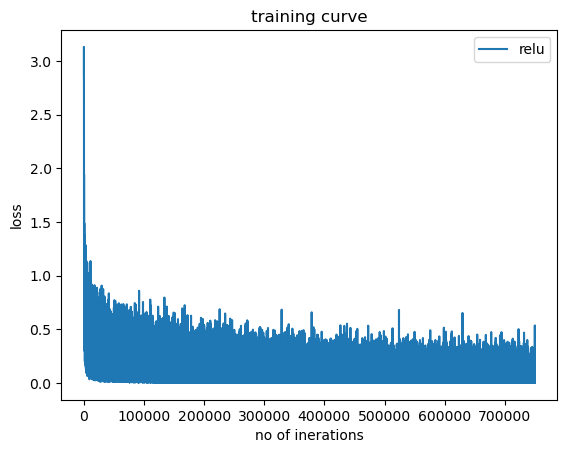

In [22]:
#plotting the training loss

plt.plot(loss_list, label='relu')
plt.ylabel('loss')
plt.xlabel('no of inerations')
plt.title('training curve')
plt.legend()
plt.show()

In [23]:
df_test = pd.read_csv('/home/bibin/MAI/2nd_sem/ANN/dataset/test.csv')

In [24]:
df_test

,id,image,classification
0,240000,240000.png,NaN
1,240001,240001.png,NaN
2,240002,240002.png,NaN
3,240003,240003.png,NaN
4,240004,240004.png,NaN
...,...,...,...
39995,279995,279995.png,NaN
39996,279996,279996.png,NaN
39997,279997,279997.png,NaN
39998,279998,279998.png,NaN


In [25]:
test_im = df_test['image'].to_list()

In [26]:
len(test_im)

40000

In [27]:
zero_test = np.zeros((40000,28,28),dtype=np.uint8) 

In [28]:
for i in range(40000):
    zero_test[i] = cv2.imread(f'dataset/test/{test_im[i]}',0)

In [29]:
zero_test = zero_test/255 #normalizing data

In [30]:
test_images = torch.FloatTensor(zero_test).reshape((40000,1,28,28)) # convert from numpy array into torch tensor with shape(240000,1,28,28)

In [31]:
# Set the model to evaluation mode
modelRelu.eval() #Dropout layers do not drop out any neurons during evaluation and BatchNorm layers use the mean and standard deviation of the entire dataset instead of mini-batch.

classification = []
for x in test_images:
            z = modelRelu(x.view(-1, 28 * 28)) #The image is first reshaped to a 1D tensor of size (1, 784) using the view() method.
            pred = torch.argmax(z).item() #The argmax() function is used to get the index of the class with the highest predicted probability.
                                          #item() function is used to convert the tensor to a Python int and it is appended to the "classification" list
            classification.append(pred)

In [32]:
classification

[6,
 9,
 0,
 8,
 2,
 9,
 6,
 0,
 7,
 4,
 2,
 3,
 2,
 9,
 7,
 1,
 1,
 0,
 3,
 2,
 6,
 9,
 1,
 6,
 0,
 2,
 2,
 6,
 0,
 3,
 0,
 2,
 5,
 3,
 7,
 0,
 2,
 5,
 5,
 3,
 2,
 0,
 5,
 9,
 8,
 7,
 9,
 8,
 7,
 3,
 4,
 1,
 2,
 0,
 9,
 7,
 5,
 4,
 4,
 8,
 9,
 4,
 0,
 3,
 0,
 6,
 3,
 4,
 2,
 6,
 9,
 1,
 8,
 2,
 4,
 7,
 1,
 9,
 2,
 3,
 3,
 6,
 4,
 7,
 1,
 9,
 4,
 4,
 1,
 1,
 8,
 5,
 3,
 2,
 9,
 4,
 4,
 0,
 5,
 1,
 1,
 8,
 4,
 3,
 7,
 3,
 3,
 9,
 0,
 3,
 1,
 1,
 5,
 0,
 6,
 6,
 7,
 8,
 0,
 5,
 7,
 7,
 8,
 5,
 3,
 0,
 9,
 5,
 7,
 7,
 2,
 4,
 8,
 8,
 5,
 7,
 2,
 9,
 4,
 8,
 4,
 5,
 3,
 7,
 6,
 7,
 2,
 0,
 1,
 3,
 2,
 8,
 4,
 9,
 6,
 9,
 5,
 5,
 0,
 6,
 6,
 0,
 2,
 1,
 2,
 1,
 3,
 0,
 1,
 4,
 9,
 2,
 5,
 9,
 9,
 0,
 8,
 3,
 1,
 8,
 7,
 7,
 9,
 8,
 9,
 9,
 2,
 9,
 0,
 7,
 0,
 4,
 8,
 2,
 9,
 2,
 2,
 5,
 5,
 2,
 7,
 0,
 1,
 2,
 6,
 7,
 3,
 6,
 2,
 6,
 2,
 9,
 0,
 4,
 2,
 9,
 9,
 6,
 0,
 1,
 2,
 3,
 6,
 4,
 0,
 6,
 8,
 5,
 9,
 4,
 9,
 0,
 3,
 1,
 5,
 8,
 9,
 9,
 3,
 3,
 6,
 3,
 4,
 4,
 4,
 5,
 3,
 8,
 8,
 6,


In [33]:
import pandas as pd

classification_df = pd.DataFrame (classification, columns = ['classification'])

In [34]:
classification_df

,classification
0,6
1,9
2,0
3,8
4,2
...,...
39995,0
39996,8
39997,6
39998,8


In [35]:
df_test_submission = pd.read_csv('/home/bibin/MAI/2nd_sem/ANN/dataset/test_copy.csv')

In [36]:
df_test_submission

,id,image,classification
0,240000,240000.png,NaN
1,240001,240001.png,NaN
2,240002,240002.png,NaN
3,240003,240003.png,NaN
4,240004,240004.png,NaN
...,...,...,...
39995,279995,279995.png,NaN
39996,279996,279996.png,NaN
39997,279997,279997.png,NaN
39998,279998,279998.png,NaN


In [37]:
df_test_submission.pop('image') #pop() method to remove the "image" column from the "df_test_submission" DataFrame.

0        240000.png
1        240001.png
2        240002.png
3        240003.png
4        240004.png
            ...    
39995    279995.png
39996    279996.png
39997    279997.png
39998    279998.png
39999    279999.png
Name: image, Length: 40000, dtype: object

In [38]:
df_test_submission

,id,classification
0,240000,NaN
1,240001,NaN
2,240002,NaN
3,240003,NaN
4,240004,NaN
...,...,...
39995,279995,NaN
39996,279996,NaN
39997,279997,NaN
39998,279998,NaN


In [39]:
df_test_submission["classification"] = classification_df #adding classification coulmn with the predicted classes

In [40]:
df_test_submission

,id,classification
0,240000,6
1,240001,9
2,240002,0
3,240003,8
4,240004,2
...,...,...
39995,279995,0
39996,279996,8
39997,279997,6
39998,279998,8


In [41]:
df_test_submission.to_csv('/home/bibin/MAI/2nd_sem/ANN/dataset/Xavier_100ep_BN_class_Relu_6_lr4.csv', index=False)
#The "to_csv()" method is a built-in function in pandas that allows to write a DataFrame to a CSV file.

In [42]:
df_test_submission.loc[df_test_submission['id'] == 240019] #.loc property of a DataFrame to select and return a specific row of the "df_test_submission" DataFrame based on a condition. The condition is that the value of the 'id' column is equal to 240019

,id,classification
19,240019,2


In [ ]:
#MLP different model comparison
# graph shows using Adam optimizer gives more accuracy
# Batch normalisation and dropout did'nt give significant improvement, that may be for more compliacted architectures (with more hidden layers may give more effect of dropout)

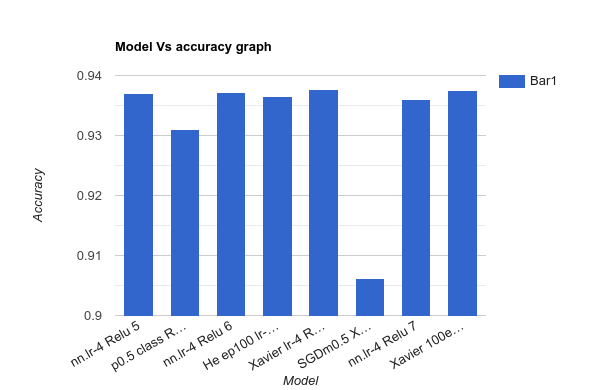